In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

import os
import pandas as pd
import numpy as np
np.random.seed(1337)
from io import StringIO
import requests, zipfile
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Activation,Dropout
from keras.layers import Dense, Input, GlobalMaxPooling1D,Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, SimpleRNN,LSTM,GRU,Bidirectional
from keras.models import Model
from keras.layers import TimeDistributed
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50
from sklearn.metrics import confusion_matrix, recall_score, precision_score,f1_score
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import r2_score#R 2
from keras.layers import Average
from keras_self_attention import SeqSelfAttention
from keras.layers.core import Layer   
from keras import backend as K 
from keras.layers import Reshape, RepeatVector,Permute, merge,Lambda
import numpy
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from keras import backend as K
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
keras.backend.set_epsilon(1)
import time
from keras.models import load_model

Using TensorFlow backend.


In [2]:
aggregate_df1 = pd.read_csv('/home/awinlab/Documents/kevin/elec220.csv',index_col='datetime',parse_dates=True)
aggregate_df1 = aggregate_df1[:900000]
training_size = int(len(aggregate_df1) * 0.8)
aggregate_df_train = aggregate_df1[training_size:]
aggregate_df_test = aggregate_df1[:training_size]

plug1_1 = pd.read_csv('/home/awinlab/Documents/kevin/plug3-3.csv',index_col='datetime',parse_dates=True)
plug1_1 = plug1_1[:900000]
plug1_1_train = plug1_1[training_size:]
plug1_1_test =  plug1_1[:training_size]

X_train = aggregate_df_train.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
X_test = aggregate_df_test.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
y_train = plug1_1_train.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
y_test = plug1_1_test.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [3]:
in_seq = X_train.reshape((len(X_train), 1))
out_seq = y_train.reshape((len(y_train), 1))

n_input = 100
nb_out = 100
train_generator = TimeseriesGenerator(in_seq, out_seq, length=n_input, batch_size=60)

nb_features = 1
input_shape=(n_input, nb_features)
model_input = Input(shape=input_shape)

def rete(y_true, y_pred):
        #Lambda(lambda x: x[0]/x[1])([K.abs(y_pred - y_true),K.maximum(y_pred, y_true)])
        return (K.abs(y_pred - y_true) / K.maximum(y_pred, y_true))

In [4]:
x = Conv1D(16, 4, activation="relu", padding="same", strides=1, input_shape=input_shape)(model_input)
x = Bidirectional(GRU(64, activation='relu', return_sequences=True), merge_mode='concat')(x)
x = (Dropout(0.5))(x)
x = Bidirectional(GRU(128, activation='relu', return_sequences=False), merge_mode='concat')(x)
x = (Dropout(0.5))(x)
x = (Dense(128, activation='relu'))(x)
x = (Dropout(0.5))(x)
x = (Dense(1, activation='linear'))(x)
model = keras.Model(model_input, x)
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mse', optimizer=adam,metrics=['mae',rete]) 

In [5]:
start = time.time()
model.fit_generator(train_generator, epochs=5, verbose=1)
end = time.time()

2022-12-20 17:49:08.010479: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-12-20 17:49:08.038716: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3499910000 Hz
2022-12-20 17:49:08.041230: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560cccbb18a0 executing computations on platform Host. Devices:
2022-12-20 17:49:08.041274: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-12-20 17:49:08.294659: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA


Epoch 1/5
2999/2999 [==============================] - 922s 307ms/step - loss: 25.7469 - mae: 3.6140 - rete: 0.1380
Epoch 2/5
2999/2999 [==============================] - 918s 306ms/step - loss: 12.4714 - mae: 2.8247 - rete: 0.1078
Epoch 3/5
2999/2999 [==============================] - 919s 306ms/step - loss: 11.8145 - mae: 2.7476 - rete: 0.1050
Epoch 4/5
2999/2999 [==============================] - 919s 306ms/step - loss: 10.9243 - mae: 2.6425 - rete: 0.1012


In [6]:
model.save("WindowGRUmodel-sensor-plug3-3.h5")
in_seq_test = X_test.reshape((len(X_test), 1))
out_seq_test = y_test.reshape((len(y_test), 1))
test_generator = TimeseriesGenerator(in_seq_test, out_seq_test, length=100, batch_size=60)
scores_test = model.evaluate_generator(test_generator)
scores_test

[2.9617180824279785, 5.6276092529296875, 0.5130459666252136]

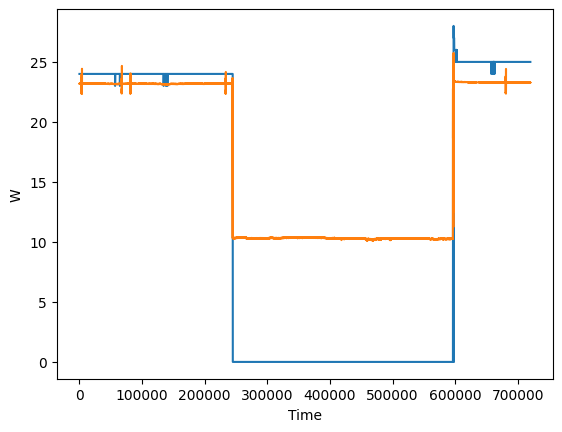

In [7]:
predict = model.predict_generator(test_generator)

plt.plot(y_test)
plt.plot(predict)
plt.xlabel('Time')
plt.ylabel("W")

plt.show()